<h1> Laboratory work 2:  Named-entity recognition (NER) </h1>

Authors: Aleksei Trutnev, Frolova Olga

## Exploratory data analysis

<h3> Dataset descriptions </h3>

The dataset <a href="https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion/data" target="_blank">  CoNLL003 (English-version) </a> is used.

In this laboratory work, we explore the fundamentals of Named Entity Recognition (NER), a key NLP task that identifies and categorizes entities in text, such as persons, organizations, and locations. NER is widely used in applications like information extraction and text analysis.

We will use the CoNLL-2003 dataset, a benchmark for NER, which provides annotated text in English and German. In this work, we consider only English language. For English, the dataset includes training, validation, and test sets, with entity categories such as Person (PER), Organization (ORG), Location (LOC), and Miscellaneous (MISC). The annotations follow the BIO tagging scheme, marking tokens as Beginning (B), Inside (I), or Outside (O) of entities.

In [1]:
import pandas as pd
from src.preprocessing import (set_seed,
                               load_sentences,
                               analyze_data_quality,
                               label_frequency_analysis,
                               labels_distribution_charts,
                               rare_and_dominant_categories,
                               entity_neighbors, plot_multiple_entity_neighbors,
                               generate_wordcloud_from_tokens_on_subplots,
                               remove_duplicates, remove_noise_from_data,
                               remove_stop_words_from_dataset,
                               remove_special_characters_from_dataset,
                               evaluate_ner
                               )
from src.RuleBasedApproach import RuleBasedNER

set_seed()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgafrolova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Download data

In [2]:
train_samples = load_sentences('./data/train.txt')
test_samples = load_sentences('./data/test.txt')
valid_samples = load_sentences('./data/valid.txt')

In [3]:
schema = ['_'] + sorted({tag for sentence in (train_samples + test_samples + valid_samples) 
                             for _, tag in sentence})
schema

['_',
 'B-LOC',
 'B-MISC',
 'B-ORG',
 'B-PER',
 'I-LOC',
 'I-MISC',
 'I-ORG',
 'I-PER',
 'O']

There total have four NER types, LOC, MISC, ORG, PER, combine with the three location type, B,I,O. This task is a 9 classification task.

* O - word doesn’t correspond to any entity.
* B-PER/I-PER - word corresponds to the beginning of / is inside a person entity.
* B-ORG/I-ORG - word corresponds to the beginning of / is inside an organization entity.
* B-LOC/I-LOC - word corresponds to the beginning of / is inside a location entity.
* B-MISC/I-MISC - word corresponds to the beginning of / is inside a miscellaneous entity.

## EDA


### General information about the dataset

In [4]:
print(f"Train set length: {len(train_samples)}, leghth of the longest sentence is {max([len(item) for item in train_samples])}")
print(f"Valid set length: {len(valid_samples)}, leghth of the longest sentence is {max([len(item) for item in valid_samples])}")
print(f"Test set length: {len(test_samples)}, leghth of the longest sentence is {max([len(item) for item in test_samples])}")

Train set length: 14041, leghth of the longest sentence is 113
Valid set length: 3250, leghth of the longest sentence is 109
Test set length: 3453, leghth of the longest sentence is 124


In [5]:
print(f"Train dataset quality:\n {analyze_data_quality(train_samples)}")
print(f"Test dataset quality:\n {analyze_data_quality(test_samples)}")
print(f"Validation dataset quality:\n {analyze_data_quality(valid_samples)}")


Train dataset quality:
 {'total_tokens': 203621, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Test dataset quality:
 {'total_tokens': 46435, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}
Validation dataset quality:
 {'total_tokens': 51362, 'invalid_tokens': 0, 'empty_sentences': 0, 'empty_sentence_percentage': 0.0, 'invalid_token_percentage': 0.0}


### Analysis of entity categories

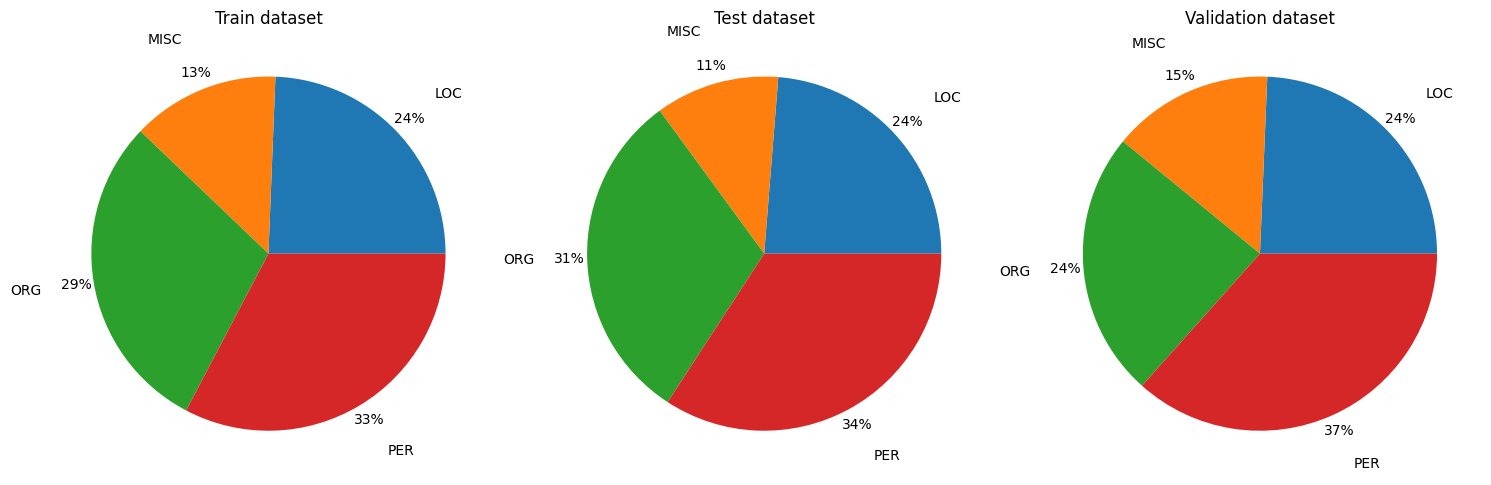

In [6]:
labels_distribution_charts(
    label_frequency_analysis(train_samples),
    label_frequency_analysis(test_samples),
    label_frequency_analysis(valid_samples),
    )

In [7]:
print(f"Rare and dominant entities in train dataset:\n {rare_and_dominant_categories(train_samples)}")
print(f"Rare and dominant entities in test dataset:\n {rare_and_dominant_categories(test_samples)}")
print(f"Rare and dominant entities in validation dataset:\n {rare_and_dominant_categories(valid_samples)}")

Rare and dominant entities in train dataset:
 {'total_tokens': 203621, 'top_categories': {'B-LOC': 3.506514553999833, 'O': 83.2811939829389}, 'worst_categories': {'I-MISC': 0.5672302954999731, 'I-LOC': 0.5682125124618777}}
Rare and dominant entities in test dataset:
 {'total_tokens': 46435, 'top_categories': {'B-LOC': 3.592118014428771, 'O': 82.53041886508022}, 'worst_categories': {'I-MISC': 0.4651663615807042, 'I-LOC': 0.5534618283622268}}
Rare and dominant entities in validation dataset:
 {'total_tokens': 51362, 'top_categories': {'B-PER': 3.58630894435575, 'O': 83.25026284023208}, 'worst_categories': {'I-LOC': 0.5003699232895915, 'I-MISC': 0.6736497799929909}}


<b>NOTE</b>

<b>Data distribution</b>
Based on the provided pie charts, we can see how the entity classes are distributed in the three datasets (training, test and validation):

1. Train dataset:

PER (33%): Predominant class. This indicates a large number of personal entities in the data.
ORG (29%): Nearly one-third of the data contains mentions of organizations.
LOC (24%): A significant proportion of the data refers to geographic entities.
MISC (13%): The lowest proportion of entities, possibly due to less certainty in their classification.

2. Test dataset:

PER (34%): The most represented class, the proportion is slightly higher than in the training sample.
ORG (31%): Organizations also make up a significant portion of the data.
LOC (24%): The level is the same as in the training sample.
MISC (11%): The rarest class, the proportion is even smaller than in the training sample.

3. Validation dataset:

PER (37%): Maximum proportion compared to other samples. This may create some imbalance.
ORG (24%): Decrease compared to other sets.
LOC (24%): Stable level.
MISC (15%): Highest proportion among all sets.



<b>Data balance:</b>

The main entity types (PER, ORG, LOC) are fairly evenly distributed, although PER is the most dominant class.
Entities of type MISC occupy a significantly smaller proportion, especially in the test sample. This may lead to insufficient generalization of the model for such entities.

<b>Differences between datasets:</b>

The validation set has a higher proportion of PER class than the other sets. This may bias the model quality assessment towards this class.
The proportion of ORG is lower in the validation sample, which may affect the correctness of the estimation for entities.

<b>Model complexity:</b>

Due to the presence of 9 classes, classification requires considering not only the type of entity, but also the position of the word within the entity (beginning or continuation). This increases the complexity of the task, especially for rare classes such as MISC.



### WordCloud

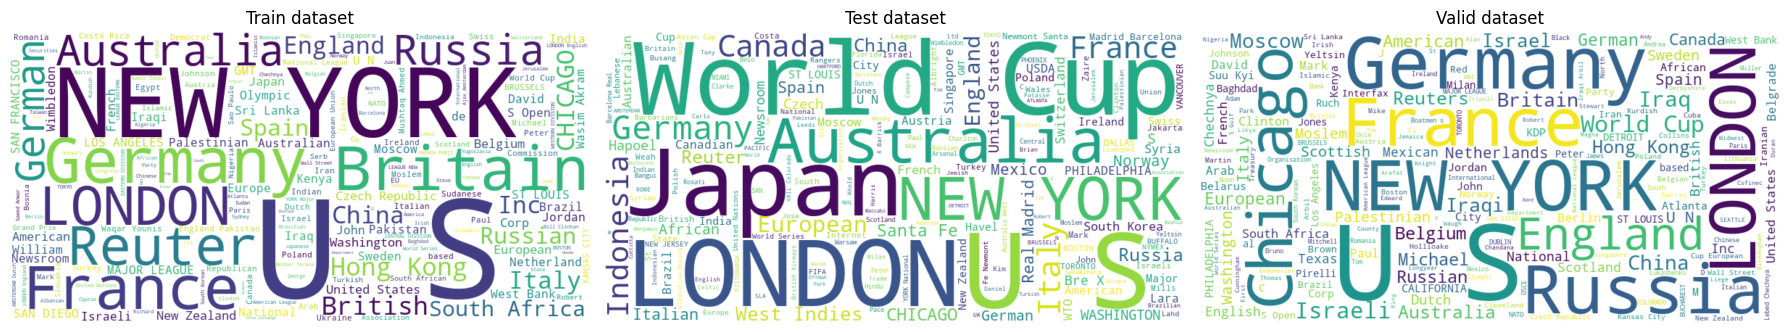

In [8]:
generate_wordcloud_from_tokens_on_subplots(
    train_samples, 
    test_samples, 
    valid_samples
)

<b>NOTE</b>

<b>General observations:</b>

The major entities repeated in each dataset are NEW YORK, U.S., GERMANY, FRANCE, and LONDON. This indicates that the data has some similarity in the composition of key entities.
Mentions of countries, cities, organizations and other international entities are predominant, which is consistent with the task of recognizing geographical and organizational entities.

* <b> Train dataset:</b>
Entities such as NEW YORK, U.S., GERMANY, LONDON, FRANCE are frequent, reflecting an emphasis on international entities and cities.
A variety of entities related to specific regions are present, e.g. SAN DIEGO, HONG KONG, AUSTRALIA.
Mention of news sources such as Reuters suggests possible use of texts from news stories.

* <b> Test dataset: </b> 
Frequent entities are similar to the training sample: NEW YORK, JAPAN, U.S., LONDON, FRANCE.
There is increased representation of Asian countries such as JAPAN, INDONESIA, CHINA.
Sports references such as World Cup are present, which may indicate sports-related texts.

* <b>  Validation dataset: </b> 
Frequent entities include NEW YORK, GERMANY, FRANCE, RUSSIA, which creates overlap with other sets.
References to countries with a tense political or international agenda are present, e.g. IRAQ, PALESTINIAN, which may indicate the theme of geopolitics in the texts.

<b>Comparative Analysis:</b>
* <b>Similarity:</b>
All three samples have significant overlap in key entities such as NEW YORK, U.S., GERMANY, FRANCE, which provides consistency across datasets and may contribute to better model training.
* <b>Differences:</b>
The validation sample stands out with a greater emphasis on Asian countries (JAPAN, INDONESIA) and sporting events (World Cup).
The validation sample has more entities related to political agenda and international conflicts (IRAQ, PALESTINIAN, ISRAELI).

### Proposition-level analysis

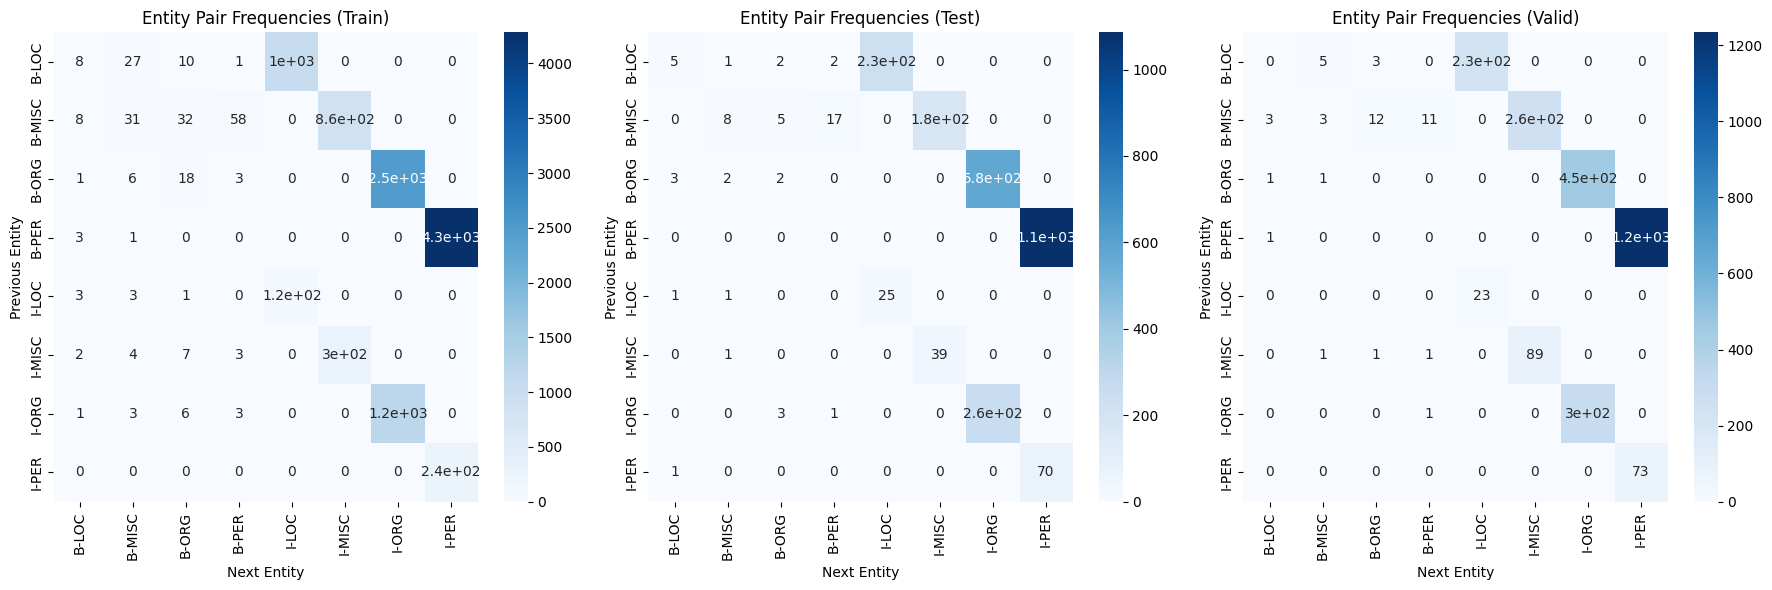

In [9]:
plot_multiple_entity_neighbors(
    entity_neighbors(train_samples),
    entity_neighbors(test_samples),
    entity_neighbors(valid_samples)
)

<b> NOTE</b>

<b>Frequent entity pairs:</b>

In each dataset, there is a high frequency of transitions between similar entities (e.g., B-LOC → I-LOC, B-PER → I-PER, B-ORG → I-ORG). This indicates that entities tend to have multiple tokens (words within the same entity).

<b>Rare transitions:</b>

Transitions between different entity types (e.g., B-LOC → B-ORG or B-MISC → B-PER) are less frequent, which is consistent with the nature of texts, where entities are usually contextually related within the same type.
Some transitions are almost absent, indicating that the data is strictly structured (e.g., I-LOC → B-ORG).

<b>Comparison of datasets:</b>

Training sample: Most balanced, with frequent transitions well represented, e.g., B-ORG → I-ORG and B-PER → I-PER.
Test sample: There is a decrease in the frequency of transitions, especially between different types of entities. This may be indicative of the more “narrow” subject matter of the data.
Validation sample: Also shows less pronounced transitions between different entities, which is probably due to the smaller amount of data.

The most frequent transitions are:
B-PER → I-PER: Occurs frequently in all sets, which is logical for first and last names.
B-LOC → I-LOC: Occurs frequently because geographic names are often composed of several words (e.g., New York).
B-ORG → I-ORG: Transitions within organizations are also quite frequent.

### Remove duplicate

In [10]:
train_samples = remove_duplicates(train_samples)
test_samples = remove_duplicates(test_samples)
valid_samples = remove_duplicates(valid_samples)

### Remove noise data

In [11]:
train_samples = remove_noise_from_data(train_samples)
test_samples = remove_noise_from_data(test_samples)
valid_samples = remove_noise_from_data(valid_samples)

### Remove stop word

In [12]:
train_samples = remove_stop_words_from_dataset(train_samples)
test_samples = remove_stop_words_from_dataset(test_samples)
valid_samples = remove_stop_words_from_dataset(valid_samples)

### Remove special characters

In [13]:
train_samples = remove_special_characters_from_dataset(train_samples)
test_samples = remove_special_characters_from_dataset(test_samples)
valid_samples = remove_special_characters_from_dataset(valid_samples)

<b> NOTE </b>

Removing duplicates, noise, stop words and special characters improves the quality of the training sample. It helps the model:

Focus on meaningful patterns.
Speed up training by reducing the amount of irrelevant data.
Increase robustness to errors and reduce the likelihood of overtraining.

## Rule based approach


In [14]:
from typing import List

def create_corpus(token_sentences: List[list]) -> dict:
    dataset_corpus = []
    for sentence in token_sentences:
        tokens = [token for token, _ in sentence]
        dataset_corpus.append({'text': " ".join(tokens),
                               'target':  sentence})
    return dataset_corpus

In [15]:
train_dataset = create_corpus(train_samples)
test_dataset = create_corpus(test_samples)
val_dataset = create_corpus(valid_samples)

In [16]:
model = RuleBasedNER()
result = model.process_dataset(train_dataset)

In [17]:
metrics = evaluate_ner(result)
rule_based_metric = pd.DataFrame(metrics, columns=list(metrics.keys()), index=['Score'])

In [18]:
rule_based_metric

,accuracy,precision,recall,f1-score
Score,0.51901,0.301088,0.289567,0.284405


# NN

In [19]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003", trust_remote_code=True)
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names

/Users/olgafrolova/Documents/ВШЭ/магистратура(2 курс)/Компьютерная лингвистика(Санжар)/nlp-ner/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [21]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [22]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map: 100%|██████████| 3453/3453 [00:00<00:00, 28784.81 examples/s]


In [23]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [24]:
import numpy as np
import evaluate

metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [25]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [26]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from transformers import TrainingArguments

NUM_EPOCHS=3


args = TrainingArguments(
    "data/checkpoint",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    learning_rate=2e-5,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01
)

In [28]:
train_subset_ratio = 0.05
from torch.utils.data import Subset

tokenized_datasets["train"] = Subset(
    tokenized_datasets["train"],
    list(range(int(train_subset_ratio*len(tokenized_datasets["train"]))))
)

eval_subset_ratio = 0.25
tokenized_datasets["validation"] = Subset(
    tokenized_datasets["validation"],
    list(range(int(eval_subset_ratio*len(tokenized_datasets["validation"]))))
)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

## Fine-tuning

In [30]:
trainer.train()

  0%|          | 1/264 [00:04<19:36,  4.47s/it]

{'loss': 2.3144, 'grad_norm': 8.772104263305664, 'learning_rate': 1.9924242424242425e-05, 'epoch': 0.01}


  1%|          | 2/264 [00:05<10:08,  2.32s/it]

{'loss': 2.1843, 'grad_norm': 6.733085632324219, 'learning_rate': 1.984848484848485e-05, 'epoch': 0.02}


  1%|          | 3/264 [00:05<06:49,  1.57s/it]

{'loss': 2.008, 'grad_norm': 8.320390701293945, 'learning_rate': 1.9772727272727274e-05, 'epoch': 0.03}


  2%|▏         | 4/264 [00:06<05:01,  1.16s/it]

{'loss': 1.8127, 'grad_norm': 8.475273132324219, 'learning_rate': 1.96969696969697e-05, 'epoch': 0.05}


  2%|▏         | 5/264 [00:06<03:49,  1.13it/s]

{'loss': 1.7212, 'grad_norm': 6.257887363433838, 'learning_rate': 1.9621212121212123e-05, 'epoch': 0.06}


  2%|▏         | 6/264 [00:07<02:53,  1.48it/s]

{'loss': 1.7061, 'grad_norm': 5.780424118041992, 'learning_rate': 1.9545454545454546e-05, 'epoch': 0.07}


  3%|▎         | 7/264 [00:07<02:30,  1.71it/s]

{'loss': 1.5671, 'grad_norm': 5.562726974487305, 'learning_rate': 1.9469696969696972e-05, 'epoch': 0.08}


  3%|▎         | 8/264 [00:08<02:31,  1.68it/s]

{'loss': 1.4017, 'grad_norm': 5.9005889892578125, 'learning_rate': 1.9393939393939395e-05, 'epoch': 0.09}


  3%|▎         | 9/264 [00:09<02:55,  1.45it/s]

{'loss': 1.3258, 'grad_norm': 5.186366081237793, 'learning_rate': 1.931818181818182e-05, 'epoch': 0.1}


  4%|▍         | 10/264 [00:09<02:36,  1.62it/s]

{'loss': 1.2255, 'grad_norm': 4.53378963470459, 'learning_rate': 1.9242424242424244e-05, 'epoch': 0.11}


  4%|▍         | 11/264 [00:09<02:11,  1.92it/s]

{'loss': 1.2672, 'grad_norm': 3.384850263595581, 'learning_rate': 1.916666666666667e-05, 'epoch': 0.12}


  5%|▍         | 12/264 [00:10<01:58,  2.12it/s]

{'loss': 0.9833, 'grad_norm': 3.1008002758026123, 'learning_rate': 1.9090909090909094e-05, 'epoch': 0.14}


  5%|▌         | 14/264 [00:10<01:20,  3.11it/s]

{'loss': 0.9288, 'grad_norm': 2.636840581893921, 'learning_rate': 1.9015151515151516e-05, 'epoch': 0.15}
{'loss': 1.1987, 'grad_norm': 4.190523624420166, 'learning_rate': 1.8939393939393943e-05, 'epoch': 0.16}


  6%|▌         | 15/264 [00:10<01:04,  3.84it/s]

{'loss': 0.84, 'grad_norm': 2.6233880519866943, 'learning_rate': 1.8863636363636366e-05, 'epoch': 0.17}


  6%|▌         | 16/264 [00:10<01:04,  3.82it/s]

{'loss': 0.711, 'grad_norm': 2.2460176944732666, 'learning_rate': 1.8787878787878792e-05, 'epoch': 0.18}


  6%|▋         | 17/264 [00:11<01:16,  3.23it/s]

{'loss': 0.9388, 'grad_norm': 3.7066245079040527, 'learning_rate': 1.871212121212121e-05, 'epoch': 0.19}


  7%|▋         | 18/264 [00:12<01:43,  2.38it/s]

{'loss': 0.9989, 'grad_norm': 3.7061822414398193, 'learning_rate': 1.8636363636363638e-05, 'epoch': 0.2}


  8%|▊         | 20/264 [00:12<01:24,  2.90it/s]

{'loss': 1.0814, 'grad_norm': 4.5439982414245605, 'learning_rate': 1.856060606060606e-05, 'epoch': 0.22}
{'loss': 0.597, 'grad_norm': 2.523023843765259, 'learning_rate': 1.8484848484848487e-05, 'epoch': 0.23}


  8%|▊         | 21/264 [00:13<01:29,  2.71it/s]

{'loss': 0.5798, 'grad_norm': 2.796339511871338, 'learning_rate': 1.840909090909091e-05, 'epoch': 0.24}


  8%|▊         | 22/264 [00:13<01:33,  2.58it/s]

{'loss': 0.807, 'grad_norm': 2.438241481781006, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25}


  9%|▊         | 23/264 [00:13<01:34,  2.55it/s]

{'loss': 1.186, 'grad_norm': 3.074450969696045, 'learning_rate': 1.825757575757576e-05, 'epoch': 0.26}


  9%|▉         | 24/264 [00:14<01:30,  2.64it/s]

{'loss': 0.9044, 'grad_norm': 2.5715560913085938, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.27}


 10%|▉         | 26/264 [00:14<01:13,  3.23it/s]

{'loss': 0.9099, 'grad_norm': 2.7463338375091553, 'learning_rate': 1.810606060606061e-05, 'epoch': 0.28}
{'loss': 0.631, 'grad_norm': 2.6277997493743896, 'learning_rate': 1.803030303030303e-05, 'epoch': 0.3}


 11%|█         | 28/264 [00:15<00:54,  4.36it/s]

{'loss': 0.8921, 'grad_norm': 2.2653520107269287, 'learning_rate': 1.7954545454545454e-05, 'epoch': 0.31}
{'loss': 0.8718, 'grad_norm': 2.6776952743530273, 'learning_rate': 1.787878787878788e-05, 'epoch': 0.32}


 11%|█▏        | 30/264 [00:15<00:43,  5.33it/s]

{'loss': 0.6936, 'grad_norm': 2.094635486602783, 'learning_rate': 1.7803030303030303e-05, 'epoch': 0.33}
{'loss': 0.8929, 'grad_norm': 3.5651988983154297, 'learning_rate': 1.772727272727273e-05, 'epoch': 0.34}


 12%|█▏        | 31/264 [00:15<00:41,  5.62it/s]

{'loss': 0.7386, 'grad_norm': 2.0809097290039062, 'learning_rate': 1.7651515151515153e-05, 'epoch': 0.35}


 12%|█▏        | 32/264 [00:15<00:52,  4.40it/s]

{'loss': 0.6173, 'grad_norm': 2.2576944828033447, 'learning_rate': 1.7575757575757576e-05, 'epoch': 0.36}


 13%|█▎        | 34/264 [00:16<00:50,  4.60it/s]

{'loss': 0.3699, 'grad_norm': 1.6037354469299316, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}
{'loss': 0.5571, 'grad_norm': 2.729400396347046, 'learning_rate': 1.7424242424242425e-05, 'epoch': 0.39}


 14%|█▎        | 36/264 [00:16<00:54,  4.22it/s]

{'loss': 0.5425, 'grad_norm': 2.0630791187286377, 'learning_rate': 1.734848484848485e-05, 'epoch': 0.4}
{'loss': 0.536, 'grad_norm': 2.2372169494628906, 'learning_rate': 1.7272727272727274e-05, 'epoch': 0.41}


 14%|█▍        | 38/264 [00:17<00:53,  4.24it/s]

{'loss': 0.7657, 'grad_norm': 2.9027950763702393, 'learning_rate': 1.71969696969697e-05, 'epoch': 0.42}
{'loss': 0.7309, 'grad_norm': 3.733686923980713, 'learning_rate': 1.7121212121212123e-05, 'epoch': 0.43}


 15%|█▌        | 40/264 [00:17<00:50,  4.47it/s]

{'loss': 0.3621, 'grad_norm': 1.4951339960098267, 'learning_rate': 1.7045454545454546e-05, 'epoch': 0.44}
{'loss': 0.6183, 'grad_norm': 2.8442866802215576, 'learning_rate': 1.6969696969696972e-05, 'epoch': 0.45}


 16%|█▌        | 42/264 [00:18<00:39,  5.66it/s]

{'loss': 0.3193, 'grad_norm': 6.199986457824707, 'learning_rate': 1.6893939393939395e-05, 'epoch': 0.47}
{'loss': 0.7337, 'grad_norm': 3.9042110443115234, 'learning_rate': 1.681818181818182e-05, 'epoch': 0.48}


 16%|█▋        | 43/264 [00:18<00:53,  4.16it/s]

{'loss': 0.4709, 'grad_norm': 2.6140100955963135, 'learning_rate': 1.6742424242424245e-05, 'epoch': 0.49}


 17%|█▋        | 45/264 [00:19<00:50,  4.33it/s]

{'loss': 0.7181, 'grad_norm': 2.894594192504883, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5}
{'loss': 0.7315, 'grad_norm': 3.6876933574676514, 'learning_rate': 1.6590909090909094e-05, 'epoch': 0.51}


 18%|█▊        | 47/264 [00:19<00:38,  5.60it/s]

{'loss': 0.2479, 'grad_norm': 1.8473104238510132, 'learning_rate': 1.6515151515151517e-05, 'epoch': 0.52}
{'loss': 0.4563, 'grad_norm': 4.053847789764404, 'learning_rate': 1.6439393939393943e-05, 'epoch': 0.53}


 19%|█▊        | 49/264 [00:19<00:35,  6.14it/s]

{'loss': 0.4845, 'grad_norm': 1.9634227752685547, 'learning_rate': 1.6363636363636366e-05, 'epoch': 0.55}
{'loss': 0.4216, 'grad_norm': 2.43750262260437, 'learning_rate': 1.628787878787879e-05, 'epoch': 0.56}


 19%|█▉        | 51/264 [00:19<00:30,  6.88it/s]

{'loss': 0.4863, 'grad_norm': 3.1196720600128174, 'learning_rate': 1.6212121212121212e-05, 'epoch': 0.57}
{'loss': 0.5481, 'grad_norm': 3.752251148223877, 'learning_rate': 1.6136363636363638e-05, 'epoch': 0.58}


 20%|██        | 53/264 [00:20<00:31,  6.75it/s]

{'loss': 0.4618, 'grad_norm': 2.593937397003174, 'learning_rate': 1.606060606060606e-05, 'epoch': 0.59}
{'loss': 0.6604, 'grad_norm': 3.6762986183166504, 'learning_rate': 1.5984848484848484e-05, 'epoch': 0.6}


 20%|██        | 54/264 [00:20<00:31,  6.75it/s]

{'loss': 0.2914, 'grad_norm': 2.608395576477051, 'learning_rate': 1.590909090909091e-05, 'epoch': 0.61}


 21%|██        | 56/264 [00:20<00:32,  6.37it/s]

{'loss': 0.3528, 'grad_norm': 1.961222767829895, 'learning_rate': 1.5833333333333333e-05, 'epoch': 0.62}
{'loss': 0.3476, 'grad_norm': 8.764476776123047, 'learning_rate': 1.575757575757576e-05, 'epoch': 0.64}


 22%|██▏       | 58/264 [00:21<00:37,  5.43it/s]

{'loss': 0.3445, 'grad_norm': 2.8099329471588135, 'learning_rate': 1.5681818181818182e-05, 'epoch': 0.65}
{'loss': 0.6011, 'grad_norm': 2.714548110961914, 'learning_rate': 1.5606060606060605e-05, 'epoch': 0.66}


 22%|██▏       | 59/264 [00:21<00:36,  5.63it/s]

{'loss': 0.3206, 'grad_norm': 2.0987536907196045, 'learning_rate': 1.553030303030303e-05, 'epoch': 0.67}


 23%|██▎       | 61/264 [00:21<00:40,  4.99it/s]

{'loss': 0.5173, 'grad_norm': 5.1734299659729, 'learning_rate': 1.5454545454545454e-05, 'epoch': 0.68}
{'loss': 0.4744, 'grad_norm': 3.350187301635742, 'learning_rate': 1.537878787878788e-05, 'epoch': 0.69}


 24%|██▍       | 63/264 [00:22<00:34,  5.83it/s]

{'loss': 0.2759, 'grad_norm': 1.6788084506988525, 'learning_rate': 1.5303030303030304e-05, 'epoch': 0.7}
{'loss': 0.4359, 'grad_norm': 2.66158390045166, 'learning_rate': 1.5227272727272728e-05, 'epoch': 0.72}


 25%|██▍       | 65/264 [00:22<00:39,  5.03it/s]

{'loss': 0.4904, 'grad_norm': 2.2281017303466797, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.73}
{'loss': 0.2211, 'grad_norm': 2.1093969345092773, 'learning_rate': 1.5075757575757577e-05, 'epoch': 0.74}


 25%|██▌       | 67/264 [00:22<00:31,  6.19it/s]

{'loss': 0.4157, 'grad_norm': 4.574793338775635, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}
{'loss': 0.5997, 'grad_norm': 6.289347171783447, 'learning_rate': 1.4924242424242425e-05, 'epoch': 0.76}


 26%|██▌       | 69/264 [00:23<00:28,  6.79it/s]

{'loss': 0.2272, 'grad_norm': 3.379845380783081, 'learning_rate': 1.484848484848485e-05, 'epoch': 0.77}
{'loss': 0.2128, 'grad_norm': 1.5187299251556396, 'learning_rate': 1.4772727272727274e-05, 'epoch': 0.78}


 27%|██▋       | 71/264 [00:23<00:37,  5.15it/s]

{'loss': 0.3329, 'grad_norm': 5.781279563903809, 'learning_rate': 1.4696969696969699e-05, 'epoch': 0.8}
{'loss': 0.1334, 'grad_norm': 1.7721655368804932, 'learning_rate': 1.4621212121212123e-05, 'epoch': 0.81}


 27%|██▋       | 72/264 [00:23<00:34,  5.49it/s]

{'loss': 0.4154, 'grad_norm': 1.9158414602279663, 'learning_rate': 1.4545454545454546e-05, 'epoch': 0.82}


 28%|██▊       | 74/264 [00:24<00:46,  4.10it/s]

{'loss': 0.4465, 'grad_norm': 6.965036869049072, 'learning_rate': 1.4469696969696971e-05, 'epoch': 0.83}
{'loss': 0.5957, 'grad_norm': 3.7353615760803223, 'learning_rate': 1.4393939393939396e-05, 'epoch': 0.84}


 29%|██▉       | 76/264 [00:24<00:38,  4.86it/s]

{'loss': 0.2313, 'grad_norm': 5.628124713897705, 'learning_rate': 1.431818181818182e-05, 'epoch': 0.85}
{'loss': 0.3773, 'grad_norm': 2.802610397338867, 'learning_rate': 1.4242424242424245e-05, 'epoch': 0.86}


 30%|██▉       | 78/264 [00:25<00:32,  5.71it/s]

{'loss': 0.1931, 'grad_norm': 5.214194297790527, 'learning_rate': 1.416666666666667e-05, 'epoch': 0.88}
{'loss': 0.4342, 'grad_norm': 3.5873167514801025, 'learning_rate': 1.4090909090909092e-05, 'epoch': 0.89}


 30%|███       | 80/264 [00:25<00:28,  6.40it/s]

{'loss': 0.4816, 'grad_norm': 2.8329334259033203, 'learning_rate': 1.4015151515151517e-05, 'epoch': 0.9}
{'loss': 0.1827, 'grad_norm': 8.60257339477539, 'learning_rate': 1.3939393939393942e-05, 'epoch': 0.91}


 31%|███       | 82/264 [00:25<00:28,  6.50it/s]

{'loss': 0.4333, 'grad_norm': 2.268686056137085, 'learning_rate': 1.3863636363636366e-05, 'epoch': 0.92}
{'loss': 0.1751, 'grad_norm': 2.038297176361084, 'learning_rate': 1.378787878787879e-05, 'epoch': 0.93}


 32%|███▏      | 84/264 [00:25<00:28,  6.43it/s]

{'loss': 0.3428, 'grad_norm': 2.689069986343384, 'learning_rate': 1.3712121212121212e-05, 'epoch': 0.94}
{'loss': 0.7432, 'grad_norm': 14.51445198059082, 'learning_rate': 1.3636363636363637e-05, 'epoch': 0.95}


 33%|███▎      | 86/264 [00:26<00:27,  6.51it/s]

{'loss': 0.4627, 'grad_norm': 8.133330345153809, 'learning_rate': 1.3560606060606061e-05, 'epoch': 0.97}
{'loss': 0.5622, 'grad_norm': 8.62242603302002, 'learning_rate': 1.3484848484848486e-05, 'epoch': 0.98}


 33%|███▎      | 87/264 [00:26<00:26,  6.81it/s]

{'loss': 0.2286, 'grad_norm': 2.7339882850646973, 'learning_rate': 1.3409090909090909e-05, 'epoch': 0.99}


 33%|███▎      | 88/264 [00:26<00:41,  4.26it/s]

{'loss': 0.4158, 'grad_norm': 3.2662136554718018, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


                                                
 33%|███▎      | 88/264 [00:37<00:41,  4.26it/s] 

{'eval_loss': 0.34685346484184265, 'eval_precision': 0.604887983706721, 'eval_recall': 0.627906976744186, 'eval_f1': 0.616182572614108, 'eval_accuracy': 0.8963594841483074, 'eval_runtime': 10.4734, 'eval_samples_per_second': 77.53, 'eval_steps_per_second': 9.739, 'epoch': 1.0}


 34%|███▍      | 90/264 [00:39<08:00,  2.76s/it]

{'loss': 0.5098, 'grad_norm': 7.642915725708008, 'learning_rate': 1.3257575757575758e-05, 'epoch': 1.01}
{'loss': 0.2626, 'grad_norm': 1.7379542589187622, 'learning_rate': 1.3181818181818183e-05, 'epoch': 1.02}


 35%|███▍      | 92/264 [00:39<04:06,  1.43s/it]

{'loss': 0.2629, 'grad_norm': 1.3552547693252563, 'learning_rate': 1.3106060606060607e-05, 'epoch': 1.03}
{'loss': 0.5278, 'grad_norm': 6.389903545379639, 'learning_rate': 1.3030303030303032e-05, 'epoch': 1.05}


 36%|███▌      | 94/264 [00:39<02:10,  1.30it/s]

{'loss': 0.4794, 'grad_norm': 4.496960639953613, 'learning_rate': 1.2954545454545455e-05, 'epoch': 1.06}
{'loss': 0.0923, 'grad_norm': 3.395916700363159, 'learning_rate': 1.287878787878788e-05, 'epoch': 1.07}


 36%|███▋      | 96/264 [00:40<01:17,  2.16it/s]

{'loss': 0.4584, 'grad_norm': 2.613802433013916, 'learning_rate': 1.2803030303030304e-05, 'epoch': 1.08}
{'loss': 0.1127, 'grad_norm': 1.3583749532699585, 'learning_rate': 1.2727272727272728e-05, 'epoch': 1.09}


 37%|███▋      | 98/264 [00:40<00:52,  3.14it/s]

{'loss': 0.2684, 'grad_norm': 2.3100266456604004, 'learning_rate': 1.2651515151515153e-05, 'epoch': 1.1}
{'loss': 0.4997, 'grad_norm': 3.509841203689575, 'learning_rate': 1.2575757575757576e-05, 'epoch': 1.11}


 38%|███▊      | 100/264 [00:40<00:38,  4.25it/s]

{'loss': 0.437, 'grad_norm': 3.609870672225952, 'learning_rate': 1.25e-05, 'epoch': 1.12}
{'loss': 0.4665, 'grad_norm': 3.719714403152466, 'learning_rate': 1.2424242424242425e-05, 'epoch': 1.14}


 39%|███▊      | 102/264 [00:41<00:36,  4.45it/s]

{'loss': 0.3263, 'grad_norm': 4.265539169311523, 'learning_rate': 1.234848484848485e-05, 'epoch': 1.15}
{'loss': 0.3769, 'grad_norm': 5.354118347167969, 'learning_rate': 1.2272727272727274e-05, 'epoch': 1.16}


 39%|███▉      | 104/264 [00:41<00:31,  5.02it/s]

{'loss': 0.2636, 'grad_norm': 2.5211808681488037, 'learning_rate': 1.2196969696969699e-05, 'epoch': 1.17}
{'loss': 0.0713, 'grad_norm': 0.7704452872276306, 'learning_rate': 1.2121212121212122e-05, 'epoch': 1.18}


 40%|███▉      | 105/264 [00:41<00:30,  5.27it/s]

{'loss': 0.2136, 'grad_norm': 1.4069440364837646, 'learning_rate': 1.2045454545454547e-05, 'epoch': 1.19}


 41%|████      | 107/264 [00:42<00:32,  4.88it/s]

{'loss': 0.1662, 'grad_norm': 1.5992298126220703, 'learning_rate': 1.1969696969696971e-05, 'epoch': 1.2}
{'loss': 0.1996, 'grad_norm': 1.6548861265182495, 'learning_rate': 1.1893939393939396e-05, 'epoch': 1.22}


 41%|████▏     | 109/264 [00:42<00:28,  5.48it/s]

{'loss': 0.1957, 'grad_norm': 1.533090591430664, 'learning_rate': 1.181818181818182e-05, 'epoch': 1.23}
{'loss': 0.2254, 'grad_norm': 2.29998517036438, 'learning_rate': 1.1742424242424243e-05, 'epoch': 1.24}


 42%|████▏     | 111/264 [00:42<00:25,  5.99it/s]

{'loss': 0.2574, 'grad_norm': 2.3767764568328857, 'learning_rate': 1.1666666666666668e-05, 'epoch': 1.25}
{'loss': 0.4771, 'grad_norm': 27.715604782104492, 'learning_rate': 1.1590909090909093e-05, 'epoch': 1.26}


 43%|████▎     | 113/264 [00:43<00:30,  4.90it/s]

{'loss': 0.2035, 'grad_norm': 2.7449140548706055, 'learning_rate': 1.1515151515151517e-05, 'epoch': 1.27}
{'loss': 0.3627, 'grad_norm': 6.5575785636901855, 'learning_rate': 1.1439393939393942e-05, 'epoch': 1.28}


 44%|████▎     | 115/264 [00:43<00:26,  5.66it/s]

{'loss': 0.3832, 'grad_norm': 3.630485773086548, 'learning_rate': 1.1363636363636366e-05, 'epoch': 1.3}
{'loss': 0.3773, 'grad_norm': 4.587712287902832, 'learning_rate': 1.128787878787879e-05, 'epoch': 1.31}


 44%|████▍     | 117/264 [00:44<00:25,  5.71it/s]

{'loss': 0.2936, 'grad_norm': 3.047044277191162, 'learning_rate': 1.1212121212121212e-05, 'epoch': 1.32}
{'loss': 0.2136, 'grad_norm': 1.7555010318756104, 'learning_rate': 1.1136363636363637e-05, 'epoch': 1.33}


 45%|████▌     | 119/264 [00:44<00:28,  5.11it/s]

{'loss': 0.2226, 'grad_norm': 4.8381266593933105, 'learning_rate': 1.1060606060606061e-05, 'epoch': 1.34}
{'loss': 0.2452, 'grad_norm': 2.983518362045288, 'learning_rate': 1.0984848484848484e-05, 'epoch': 1.35}


 46%|████▌     | 121/264 [00:44<00:24,  5.84it/s]

{'loss': 0.1391, 'grad_norm': 4.270970821380615, 'learning_rate': 1.0909090909090909e-05, 'epoch': 1.36}
{'loss': 0.1992, 'grad_norm': 11.917367935180664, 'learning_rate': 1.0833333333333334e-05, 'epoch': 1.38}


 46%|████▌     | 122/264 [00:45<00:24,  5.79it/s]

{'loss': 0.0958, 'grad_norm': 1.809006690979004, 'learning_rate': 1.0757575757575758e-05, 'epoch': 1.39}


 47%|████▋     | 124/264 [00:45<00:26,  5.29it/s]

{'loss': 0.1233, 'grad_norm': 0.9594475030899048, 'learning_rate': 1.0681818181818183e-05, 'epoch': 1.4}
{'loss': 0.2704, 'grad_norm': 4.778430461883545, 'learning_rate': 1.0606060606060606e-05, 'epoch': 1.41}


 48%|████▊     | 126/264 [00:45<00:22,  6.03it/s]

{'loss': 0.3282, 'grad_norm': 3.1960501670837402, 'learning_rate': 1.053030303030303e-05, 'epoch': 1.42}
{'loss': 0.3216, 'grad_norm': 5.369936943054199, 'learning_rate': 1.0454545454545455e-05, 'epoch': 1.43}


 48%|████▊     | 128/264 [00:46<00:21,  6.48it/s]

{'loss': 0.1517, 'grad_norm': 1.6497515439987183, 'learning_rate': 1.037878787878788e-05, 'epoch': 1.44}
{'loss': 0.2541, 'grad_norm': 2.614130973815918, 'learning_rate': 1.0303030303030304e-05, 'epoch': 1.45}


 49%|████▉     | 130/264 [00:46<00:20,  6.47it/s]

{'loss': 0.1404, 'grad_norm': 1.9794280529022217, 'learning_rate': 1.0227272727272729e-05, 'epoch': 1.47}
{'loss': 0.2758, 'grad_norm': 15.272812843322754, 'learning_rate': 1.0151515151515152e-05, 'epoch': 1.48}


 50%|█████     | 132/264 [00:46<00:19,  6.90it/s]

{'loss': 0.0716, 'grad_norm': 0.9314984679222107, 'learning_rate': 1.0075757575757576e-05, 'epoch': 1.49}
{'loss': 0.2915, 'grad_norm': 2.209188222885132, 'learning_rate': 1e-05, 'epoch': 1.5}


 51%|█████     | 134/264 [00:46<00:18,  7.01it/s]

{'loss': 0.071, 'grad_norm': 1.342539668083191, 'learning_rate': 9.924242424242425e-06, 'epoch': 1.51}
{'loss': 0.0853, 'grad_norm': 1.4213433265686035, 'learning_rate': 9.84848484848485e-06, 'epoch': 1.52}


 52%|█████▏    | 136/264 [00:47<00:18,  6.84it/s]

{'loss': 0.1463, 'grad_norm': 2.2337939739227295, 'learning_rate': 9.772727272727273e-06, 'epoch': 1.53}
{'loss': 0.0598, 'grad_norm': 0.8440572023391724, 'learning_rate': 9.696969696969698e-06, 'epoch': 1.55}


 52%|█████▏    | 138/264 [00:47<00:19,  6.55it/s]

{'loss': 0.2171, 'grad_norm': 2.954843759536743, 'learning_rate': 9.621212121212122e-06, 'epoch': 1.56}
{'loss': 0.1178, 'grad_norm': 2.2646350860595703, 'learning_rate': 9.545454545454547e-06, 'epoch': 1.57}


 53%|█████▎    | 140/264 [00:47<00:19,  6.42it/s]

{'loss': 0.2921, 'grad_norm': 6.182663440704346, 'learning_rate': 9.469696969696971e-06, 'epoch': 1.58}
{'loss': 0.1282, 'grad_norm': 1.7068246603012085, 'learning_rate': 9.393939393939396e-06, 'epoch': 1.59}


 54%|█████▍    | 142/264 [00:48<00:23,  5.13it/s]

{'loss': 0.3588, 'grad_norm': 7.041604042053223, 'learning_rate': 9.318181818181819e-06, 'epoch': 1.6}
{'loss': 0.2231, 'grad_norm': 2.4070708751678467, 'learning_rate': 9.242424242424244e-06, 'epoch': 1.61}


 55%|█████▍    | 144/264 [00:48<00:20,  5.80it/s]

{'loss': 0.1255, 'grad_norm': 1.40973961353302, 'learning_rate': 9.166666666666666e-06, 'epoch': 1.62}
{'loss': 0.2345, 'grad_norm': 2.9529788494110107, 'learning_rate': 9.090909090909091e-06, 'epoch': 1.64}


 55%|█████▌    | 146/264 [00:49<00:20,  5.78it/s]

{'loss': 0.2059, 'grad_norm': 5.021209239959717, 'learning_rate': 9.015151515151516e-06, 'epoch': 1.65}
{'loss': 0.2379, 'grad_norm': 1.9820386171340942, 'learning_rate': 8.93939393939394e-06, 'epoch': 1.66}


 56%|█████▌    | 148/264 [00:49<00:18,  6.20it/s]

{'loss': 0.2814, 'grad_norm': 3.457639694213867, 'learning_rate': 8.863636363636365e-06, 'epoch': 1.67}
{'loss': 0.2422, 'grad_norm': 3.719292402267456, 'learning_rate': 8.787878787878788e-06, 'epoch': 1.68}


 57%|█████▋    | 150/264 [00:49<00:18,  6.19it/s]

{'loss': 0.4048, 'grad_norm': 4.772290229797363, 'learning_rate': 8.712121212121212e-06, 'epoch': 1.69}
{'loss': 0.0819, 'grad_norm': 1.5267608165740967, 'learning_rate': 8.636363636363637e-06, 'epoch': 1.7}


 58%|█████▊    | 152/264 [00:49<00:17,  6.46it/s]

{'loss': 0.1594, 'grad_norm': 3.3121092319488525, 'learning_rate': 8.560606060606062e-06, 'epoch': 1.72}
{'loss': 0.1216, 'grad_norm': 0.9632184505462646, 'learning_rate': 8.484848484848486e-06, 'epoch': 1.73}


 58%|█████▊    | 154/264 [00:50<00:16,  6.68it/s]

{'loss': 0.1151, 'grad_norm': 2.3308985233306885, 'learning_rate': 8.40909090909091e-06, 'epoch': 1.74}
{'loss': 0.0822, 'grad_norm': 2.0382611751556396, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.75}


 59%|█████▉    | 156/264 [00:50<00:16,  6.67it/s]

{'loss': 0.2977, 'grad_norm': 2.6298646926879883, 'learning_rate': 8.257575757575758e-06, 'epoch': 1.76}
{'loss': 0.0548, 'grad_norm': 1.2936298847198486, 'learning_rate': 8.181818181818183e-06, 'epoch': 1.77}


 60%|█████▉    | 158/264 [00:51<00:22,  4.62it/s]

{'loss': 0.0584, 'grad_norm': 3.369603395462036, 'learning_rate': 8.106060606060606e-06, 'epoch': 1.78}
{'loss': 0.4243, 'grad_norm': 3.668240785598755, 'learning_rate': 8.03030303030303e-06, 'epoch': 1.8}


 61%|██████    | 160/264 [00:51<00:19,  5.44it/s]

{'loss': 0.0818, 'grad_norm': 1.2614997625350952, 'learning_rate': 7.954545454545455e-06, 'epoch': 1.81}
{'loss': 0.2633, 'grad_norm': 6.769305229187012, 'learning_rate': 7.87878787878788e-06, 'epoch': 1.82}


 61%|██████▏   | 162/264 [00:51<00:17,  5.92it/s]

{'loss': 0.2644, 'grad_norm': 5.114251613616943, 'learning_rate': 7.803030303030303e-06, 'epoch': 1.83}
{'loss': 0.1593, 'grad_norm': 4.719981670379639, 'learning_rate': 7.727272727272727e-06, 'epoch': 1.84}


 62%|██████▏   | 164/264 [00:52<00:15,  6.31it/s]

{'loss': 0.1805, 'grad_norm': 2.1585330963134766, 'learning_rate': 7.651515151515152e-06, 'epoch': 1.85}
{'loss': 0.2992, 'grad_norm': 4.195989608764648, 'learning_rate': 7.5757575757575764e-06, 'epoch': 1.86}


 63%|██████▎   | 166/264 [00:52<00:14,  6.95it/s]

{'loss': 0.2469, 'grad_norm': 1.7945830821990967, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}
{'loss': 0.2152, 'grad_norm': 2.5118823051452637, 'learning_rate': 7.424242424242425e-06, 'epoch': 1.89}


 64%|██████▎   | 168/264 [00:52<00:14,  6.75it/s]

{'loss': 0.0778, 'grad_norm': 3.8153486251831055, 'learning_rate': 7.348484848484849e-06, 'epoch': 1.9}
{'loss': 0.0833, 'grad_norm': 1.5652458667755127, 'learning_rate': 7.272727272727273e-06, 'epoch': 1.91}


 64%|██████▍   | 170/264 [00:52<00:13,  7.11it/s]

{'loss': 0.4151, 'grad_norm': 6.684854507446289, 'learning_rate': 7.196969696969698e-06, 'epoch': 1.92}
{'loss': 0.2292, 'grad_norm': 6.812358856201172, 'learning_rate': 7.121212121212122e-06, 'epoch': 1.93}


 65%|██████▌   | 172/264 [00:53<00:14,  6.53it/s]

{'loss': 0.1562, 'grad_norm': 1.6461181640625, 'learning_rate': 7.045454545454546e-06, 'epoch': 1.94}
{'loss': 0.3191, 'grad_norm': 7.437904357910156, 'learning_rate': 6.969696969696971e-06, 'epoch': 1.95}


 66%|██████▌   | 174/264 [00:53<00:12,  7.14it/s]

{'loss': 0.1118, 'grad_norm': 1.369011640548706, 'learning_rate': 6.893939393939395e-06, 'epoch': 1.97}
{'loss': 0.0658, 'grad_norm': 2.2001404762268066, 'learning_rate': 6.818181818181818e-06, 'epoch': 1.98}


 66%|██████▋   | 175/264 [00:53<00:12,  6.88it/s]

{'loss': 0.0933, 'grad_norm': 1.6508160829544067, 'learning_rate': 6.742424242424243e-06, 'epoch': 1.99}


 67%|██████▋   | 176/264 [00:54<00:29,  2.95it/s]

{'loss': 0.4027, 'grad_norm': 6.980473518371582, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


                                                 
 67%|██████▋   | 176/264 [00:58<00:29,  2.95it/s]

{'eval_loss': 0.25088682770729065, 'eval_precision': 0.6807570977917982, 'eval_recall': 0.7603946441155743, 'eval_f1': 0.7183754993342211, 'eval_accuracy': 0.9251746372917786, 'eval_runtime': 3.795, 'eval_samples_per_second': 213.964, 'eval_steps_per_second': 26.877, 'epoch': 2.0}


 67%|██████▋   | 178/264 [01:00<01:58,  1.37s/it]

{'loss': 0.1847, 'grad_norm': 4.062926769256592, 'learning_rate': 6.590909090909091e-06, 'epoch': 2.01}
{'loss': 0.0577, 'grad_norm': 0.9148620367050171, 'learning_rate': 6.515151515151516e-06, 'epoch': 2.02}


 68%|██████▊   | 180/264 [01:00<01:03,  1.33it/s]

{'loss': 0.2051, 'grad_norm': 1.6864750385284424, 'learning_rate': 6.43939393939394e-06, 'epoch': 2.03}
{'loss': 0.0723, 'grad_norm': 1.7320481538772583, 'learning_rate': 6.363636363636364e-06, 'epoch': 2.05}


 69%|██████▉   | 182/264 [01:00<00:36,  2.22it/s]

{'loss': 0.1084, 'grad_norm': 2.7888574600219727, 'learning_rate': 6.287878787878788e-06, 'epoch': 2.06}
{'loss': 0.2426, 'grad_norm': 5.002317428588867, 'learning_rate': 6.212121212121213e-06, 'epoch': 2.07}


 70%|██████▉   | 184/264 [01:01<00:24,  3.27it/s]

{'loss': 0.1171, 'grad_norm': 1.3516292572021484, 'learning_rate': 6.136363636363637e-06, 'epoch': 2.08}
{'loss': 0.0746, 'grad_norm': 0.9303850531578064, 'learning_rate': 6.060606060606061e-06, 'epoch': 2.09}


 70%|███████   | 186/264 [01:01<00:16,  4.73it/s]

{'loss': 0.2169, 'grad_norm': 3.719511032104492, 'learning_rate': 5.984848484848486e-06, 'epoch': 2.1}
{'loss': 0.1078, 'grad_norm': 1.4270601272583008, 'learning_rate': 5.90909090909091e-06, 'epoch': 2.11}


 71%|███████   | 188/264 [01:01<00:13,  5.62it/s]

{'loss': 0.0202, 'grad_norm': 0.4477739930152893, 'learning_rate': 5.833333333333334e-06, 'epoch': 2.12}
{'loss': 0.0693, 'grad_norm': 2.5100438594818115, 'learning_rate': 5.7575757575757586e-06, 'epoch': 2.14}


 72%|███████▏  | 190/264 [01:01<00:12,  5.86it/s]

{'loss': 0.1167, 'grad_norm': 1.7098358869552612, 'learning_rate': 5.681818181818183e-06, 'epoch': 2.15}
{'loss': 0.216, 'grad_norm': 5.056896209716797, 'learning_rate': 5.606060606060606e-06, 'epoch': 2.16}


 73%|███████▎  | 192/264 [01:02<00:12,  5.95it/s]

{'loss': 0.0648, 'grad_norm': 2.6074914932250977, 'learning_rate': 5.530303030303031e-06, 'epoch': 2.17}
{'loss': 0.1384, 'grad_norm': 3.6399307250976562, 'learning_rate': 5.4545454545454545e-06, 'epoch': 2.18}


 73%|███████▎  | 194/264 [01:02<00:11,  6.10it/s]

{'loss': 0.0457, 'grad_norm': 0.738956093788147, 'learning_rate': 5.378787878787879e-06, 'epoch': 2.19}
{'loss': 0.1322, 'grad_norm': 3.9583899974823, 'learning_rate': 5.303030303030303e-06, 'epoch': 2.2}


 74%|███████▍  | 196/264 [01:02<00:10,  6.22it/s]

{'loss': 0.1013, 'grad_norm': 2.215256929397583, 'learning_rate': 5.2272727272727274e-06, 'epoch': 2.22}
{'loss': 0.0563, 'grad_norm': 4.1835432052612305, 'learning_rate': 5.151515151515152e-06, 'epoch': 2.23}


 75%|███████▌  | 198/264 [01:03<00:10,  6.05it/s]

{'loss': 0.1534, 'grad_norm': 1.8089438676834106, 'learning_rate': 5.075757575757576e-06, 'epoch': 2.24}
{'loss': 0.1139, 'grad_norm': 2.0827622413635254, 'learning_rate': 5e-06, 'epoch': 2.25}


 76%|███████▌  | 200/264 [01:03<00:10,  6.14it/s]

{'loss': 0.0721, 'grad_norm': 0.9419780969619751, 'learning_rate': 4.924242424242425e-06, 'epoch': 2.26}
{'loss': 0.0179, 'grad_norm': 0.33681485056877136, 'learning_rate': 4.848484848484849e-06, 'epoch': 2.27}


 77%|███████▋  | 202/264 [01:03<00:09,  6.36it/s]

{'loss': 0.1382, 'grad_norm': 2.881840229034424, 'learning_rate': 4.772727272727273e-06, 'epoch': 2.28}
{'loss': 0.1337, 'grad_norm': 2.850144386291504, 'learning_rate': 4.696969696969698e-06, 'epoch': 2.3}


 77%|███████▋  | 204/264 [01:04<00:08,  6.83it/s]

{'loss': 0.028, 'grad_norm': 0.8778933882713318, 'learning_rate': 4.621212121212122e-06, 'epoch': 2.31}
{'loss': 0.3918, 'grad_norm': 8.659526824951172, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.32}


 78%|███████▊  | 206/264 [01:04<00:09,  6.44it/s]

{'loss': 0.3503, 'grad_norm': 5.6269659996032715, 'learning_rate': 4.46969696969697e-06, 'epoch': 2.33}
{'loss': 0.0838, 'grad_norm': 1.4988462924957275, 'learning_rate': 4.393939393939394e-06, 'epoch': 2.34}


 79%|███████▉  | 208/264 [01:04<00:09,  6.08it/s]

{'loss': 0.211, 'grad_norm': 2.2348415851593018, 'learning_rate': 4.3181818181818185e-06, 'epoch': 2.35}
{'loss': 0.1597, 'grad_norm': 1.7199386358261108, 'learning_rate': 4.242424242424243e-06, 'epoch': 2.36}


 80%|███████▉  | 210/264 [01:05<00:08,  6.66it/s]

{'loss': 0.1104, 'grad_norm': 2.552140235900879, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.38}
{'loss': 0.1699, 'grad_norm': 3.022791862487793, 'learning_rate': 4.0909090909090915e-06, 'epoch': 2.39}


 80%|████████  | 212/264 [01:05<00:08,  6.49it/s]

{'loss': 0.0697, 'grad_norm': 1.3805301189422607, 'learning_rate': 4.015151515151515e-06, 'epoch': 2.4}
{'loss': 0.1793, 'grad_norm': 1.309242844581604, 'learning_rate': 3.93939393939394e-06, 'epoch': 2.41}


 81%|████████  | 214/264 [01:05<00:07,  6.47it/s]

{'loss': 0.08, 'grad_norm': 7.369720935821533, 'learning_rate': 3.863636363636364e-06, 'epoch': 2.42}
{'loss': 0.1162, 'grad_norm': 3.3667831420898438, 'learning_rate': 3.7878787878787882e-06, 'epoch': 2.43}


 82%|████████▏ | 216/264 [01:06<00:07,  6.25it/s]

{'loss': 0.2174, 'grad_norm': 2.446016788482666, 'learning_rate': 3.7121212121212124e-06, 'epoch': 2.44}
{'loss': 0.1542, 'grad_norm': 1.5618783235549927, 'learning_rate': 3.6363636363636366e-06, 'epoch': 2.45}


 83%|████████▎ | 218/264 [01:06<00:07,  6.36it/s]

{'loss': 0.1247, 'grad_norm': 2.2517361640930176, 'learning_rate': 3.560606060606061e-06, 'epoch': 2.47}
{'loss': 0.2372, 'grad_norm': 1.752825140953064, 'learning_rate': 3.4848484848484854e-06, 'epoch': 2.48}


 83%|████████▎ | 220/264 [01:06<00:06,  6.30it/s]

{'loss': 0.1539, 'grad_norm': 6.913300037384033, 'learning_rate': 3.409090909090909e-06, 'epoch': 2.49}
{'loss': 0.1434, 'grad_norm': 2.0823323726654053, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}


 84%|████████▍ | 222/264 [01:07<00:07,  5.96it/s]

{'loss': 0.0704, 'grad_norm': 1.6988292932510376, 'learning_rate': 3.257575757575758e-06, 'epoch': 2.51}
{'loss': 0.0639, 'grad_norm': 1.2515314817428589, 'learning_rate': 3.181818181818182e-06, 'epoch': 2.52}


 85%|████████▍ | 224/264 [01:07<00:06,  6.09it/s]

{'loss': 0.088, 'grad_norm': 1.214111089706421, 'learning_rate': 3.1060606060606063e-06, 'epoch': 2.53}
{'loss': 0.0524, 'grad_norm': 1.483781337738037, 'learning_rate': 3.0303030303030305e-06, 'epoch': 2.55}


 86%|████████▌ | 226/264 [01:07<00:05,  6.36it/s]

{'loss': 0.036, 'grad_norm': 0.7786654233932495, 'learning_rate': 2.954545454545455e-06, 'epoch': 2.56}
{'loss': 0.0796, 'grad_norm': 5.162570953369141, 'learning_rate': 2.8787878787878793e-06, 'epoch': 2.57}


 86%|████████▋ | 228/264 [01:07<00:05,  6.62it/s]

{'loss': 0.117, 'grad_norm': 1.487850546836853, 'learning_rate': 2.803030303030303e-06, 'epoch': 2.58}
{'loss': 0.3091, 'grad_norm': 6.1980438232421875, 'learning_rate': 2.7272727272727272e-06, 'epoch': 2.59}


 87%|████████▋ | 230/264 [01:08<00:04,  6.86it/s]

{'loss': 0.172, 'grad_norm': 3.626339912414551, 'learning_rate': 2.6515151515151514e-06, 'epoch': 2.6}
{'loss': 0.0354, 'grad_norm': 0.693081796169281, 'learning_rate': 2.575757575757576e-06, 'epoch': 2.61}


 88%|████████▊ | 232/264 [01:08<00:04,  6.98it/s]

{'loss': 0.187, 'grad_norm': 3.911297559738159, 'learning_rate': 2.5e-06, 'epoch': 2.62}
{'loss': 0.2746, 'grad_norm': 5.671757221221924, 'learning_rate': 2.4242424242424244e-06, 'epoch': 2.64}


 89%|████████▊ | 234/264 [01:08<00:04,  6.86it/s]

{'loss': 0.0467, 'grad_norm': 1.0950289964675903, 'learning_rate': 2.348484848484849e-06, 'epoch': 2.65}
{'loss': 0.0812, 'grad_norm': 1.136531114578247, 'learning_rate': 2.2727272727272728e-06, 'epoch': 2.66}


 89%|████████▉ | 236/264 [01:09<00:04,  6.96it/s]

{'loss': 0.0433, 'grad_norm': 1.1036932468414307, 'learning_rate': 2.196969696969697e-06, 'epoch': 2.67}
{'loss': 0.1284, 'grad_norm': 1.8810651302337646, 'learning_rate': 2.1212121212121216e-06, 'epoch': 2.68}


 90%|█████████ | 238/264 [01:09<00:03,  6.80it/s]

{'loss': 0.0618, 'grad_norm': 0.9785674214363098, 'learning_rate': 2.0454545454545457e-06, 'epoch': 2.69}
{'loss': 0.0803, 'grad_norm': 3.8472397327423096, 'learning_rate': 1.96969696969697e-06, 'epoch': 2.7}


 91%|█████████ | 240/264 [01:09<00:03,  7.05it/s]

{'loss': 0.0283, 'grad_norm': 0.8655017018318176, 'learning_rate': 1.8939393939393941e-06, 'epoch': 2.72}
{'loss': 0.1706, 'grad_norm': 3.7488152980804443, 'learning_rate': 1.8181818181818183e-06, 'epoch': 2.73}


 92%|█████████▏| 242/264 [01:10<00:03,  6.62it/s]

{'loss': 0.076, 'grad_norm': 2.1293118000030518, 'learning_rate': 1.7424242424242427e-06, 'epoch': 2.74}
{'loss': 0.2219, 'grad_norm': 4.78193998336792, 'learning_rate': 1.6666666666666667e-06, 'epoch': 2.75}


 92%|█████████▏| 244/264 [01:10<00:02,  6.75it/s]

{'loss': 0.1818, 'grad_norm': 3.5340685844421387, 'learning_rate': 1.590909090909091e-06, 'epoch': 2.76}
{'loss': 0.1315, 'grad_norm': 4.525168418884277, 'learning_rate': 1.5151515151515152e-06, 'epoch': 2.77}


 93%|█████████▎| 246/264 [01:10<00:02,  7.24it/s]

{'loss': 0.0304, 'grad_norm': 0.6058462858200073, 'learning_rate': 1.4393939393939396e-06, 'epoch': 2.78}
{'loss': 0.2771, 'grad_norm': 8.37672233581543, 'learning_rate': 1.3636363636363636e-06, 'epoch': 2.8}


 94%|█████████▍| 248/264 [01:10<00:02,  7.06it/s]

{'loss': 0.1756, 'grad_norm': 3.2725465297698975, 'learning_rate': 1.287878787878788e-06, 'epoch': 2.81}
{'loss': 0.1358, 'grad_norm': 1.6814438104629517, 'learning_rate': 1.2121212121212122e-06, 'epoch': 2.82}


 95%|█████████▍| 250/264 [01:11<00:02,  6.65it/s]

{'loss': 0.0328, 'grad_norm': 0.9207469820976257, 'learning_rate': 1.1363636363636364e-06, 'epoch': 2.83}
{'loss': 0.0713, 'grad_norm': 1.1412922143936157, 'learning_rate': 1.0606060606060608e-06, 'epoch': 2.84}


 95%|█████████▌| 252/264 [01:11<00:01,  6.16it/s]

{'loss': 0.1022, 'grad_norm': 4.01107120513916, 'learning_rate': 9.84848484848485e-07, 'epoch': 2.85}
{'loss': 0.0936, 'grad_norm': 7.269957065582275, 'learning_rate': 9.090909090909091e-07, 'epoch': 2.86}


 96%|█████████▌| 254/264 [01:11<00:01,  6.50it/s]

{'loss': 0.1092, 'grad_norm': 4.643731594085693, 'learning_rate': 8.333333333333333e-07, 'epoch': 2.88}
{'loss': 0.0658, 'grad_norm': 2.2951202392578125, 'learning_rate': 7.575757575757576e-07, 'epoch': 2.89}


 97%|█████████▋| 256/264 [01:12<00:01,  7.27it/s]

{'loss': 0.2425, 'grad_norm': 4.779682159423828, 'learning_rate': 6.818181818181818e-07, 'epoch': 2.9}
{'loss': 0.1203, 'grad_norm': 6.992107391357422, 'learning_rate': 6.060606060606061e-07, 'epoch': 2.91}


 98%|█████████▊| 258/264 [01:12<00:00,  6.66it/s]

{'loss': 0.1649, 'grad_norm': 2.6037983894348145, 'learning_rate': 5.303030303030304e-07, 'epoch': 2.92}
{'loss': 0.2629, 'grad_norm': 3.9334590435028076, 'learning_rate': 4.5454545454545457e-07, 'epoch': 2.93}


 98%|█████████▊| 260/264 [01:12<00:00,  6.37it/s]

{'loss': 0.0965, 'grad_norm': 3.289168119430542, 'learning_rate': 3.787878787878788e-07, 'epoch': 2.94}
{'loss': 0.2214, 'grad_norm': 5.410331726074219, 'learning_rate': 3.0303030303030305e-07, 'epoch': 2.95}


 99%|█████████▉| 262/264 [01:13<00:00,  6.66it/s]

{'loss': 0.1741, 'grad_norm': 6.57219123840332, 'learning_rate': 2.2727272727272729e-07, 'epoch': 2.97}
{'loss': 0.1236, 'grad_norm': 2.3920040130615234, 'learning_rate': 1.5151515151515152e-07, 'epoch': 2.98}


100%|█████████▉| 263/264 [01:13<00:00,  6.39it/s]

{'loss': 0.076, 'grad_norm': 1.166877031326294, 'learning_rate': 7.575757575757576e-08, 'epoch': 2.99}


100%|██████████| 264/264 [01:13<00:00,  4.16it/s]

{'loss': 0.257, 'grad_norm': 3.2464041709899902, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 264/264 [01:19<00:00,  4.16it/s]

{'eval_loss': 0.25184935331344604, 'eval_precision': 0.7270955165692008, 'eval_recall': 0.7885835095137421, 'eval_f1': 0.7565922920892495, 'eval_accuracy': 0.9322272971520688, 'eval_runtime': 3.9262, 'eval_samples_per_second': 206.814, 'eval_steps_per_second': 25.979, 'epoch': 3.0}


100%|██████████| 264/264 [01:20<00:00,  3.28it/s]

{'train_runtime': 80.4154, 'train_samples_per_second': 26.189, 'train_steps_per_second': 3.283, 'train_loss': 0.35307465993912157, 'epoch': 3.0}


TrainOutput(global_step=264, training_loss=0.35307465993912157, metrics={'train_runtime': 80.4154, 'train_samples_per_second': 26.189, 'train_steps_per_second': 3.283, 'total_flos': 42042859081776.0, 'train_loss': 0.35307465993912157, 'epoch': 3.0})